# Lab 2 : Overview

Upon completing this lab, you should have a good understanding of the fundamentals of using OpenStreetmap maps and developing local planners for Autonomous Vehicles, along with practical experience in designing, implementing, and testing local planners in a simulated environment. This hands-on experience will prepare you for further study or work in the field of autonomous vehicles.

In [1]:
# useful imports
import matplotlib.pyplot as plt
from osmnx_utils import *
import osmnx  as ox   
import networkx as nx

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Task n° 1 : Load and visualize OSM Maps
- This task involves loading an OpenStreetMap (OSM) map for a specified location using the osmnx library.
- It also visualizes the OSM graph, nodes, and edges for the given location 

First, you'll need to find a location of interest in an osm map: https://www.openstreetmap.org

/tmp/ipykernel_3593/485725308.py:5: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  ox.config(log_console=False, use_cache=True)


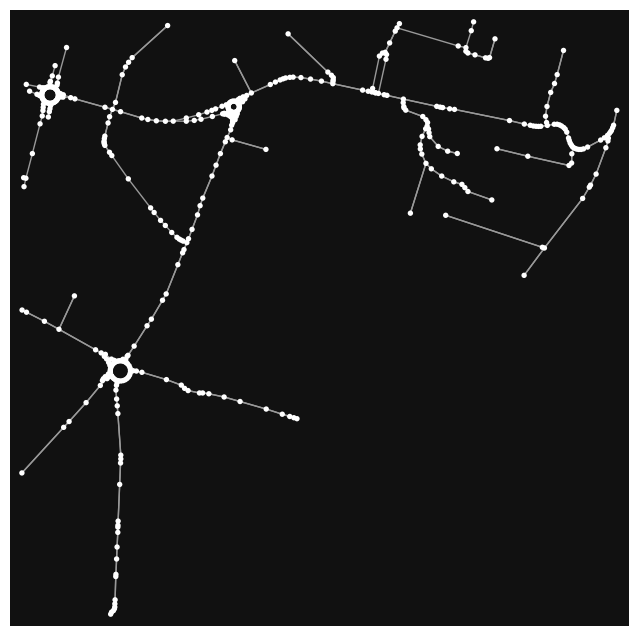

(<Figure size 800x800 with 1 Axes>, <AxesSubplot:>)

In [2]:
def create_config():
   # Place you are interested : 
    location = (47.2489965, -1.5473425) # Nantes, Ecole Centrale
    mode = "drive"
    ox.config(log_console=False, use_cache=True)

    G = ox.graph_from_point(location, dist=500, simplify=False, network_type=mode )
    return(G)

G = create_config() # This may take a while the first time

# TODO : Plot the graph and nodes according to the osmnx documentation
#module-osmnx.plot_graph(G, node_size=0, edge_color='w', edge_linewidth=0.5, bgcolor='k')
ox.plot.plot_graph(G, ax=None, figsize=(8, 8), bgcolor='#111111', node_color='w', node_size=15, node_alpha=None, node_edgecolor='none', node_zorder=1, edge_color='#999999', edge_linewidth=1, edge_alpha=None, show=True, close=False, save=False, filepath=None, dpi=300, bbox=None)


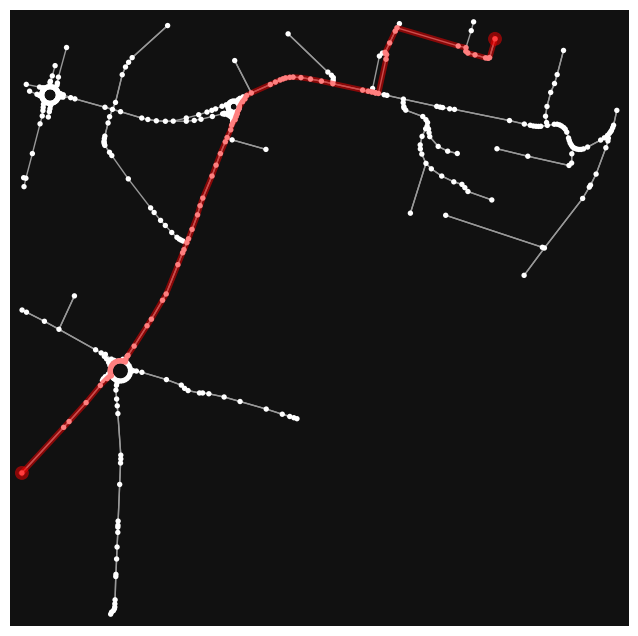

(<Figure size 800x800 with 1 Axes>, <AxesSubplot:>)

In [3]:
# Arbitrary origin and destination
origin = (round(-1.5562600,6), round(47.2467100,6))
destination = (round(-1.5428700,6), round(47.2533500,6))
origin_node = ox.nearest_nodes(G, origin[0], origin[1])
destination_node = ox.nearest_nodes(G, destination[0], destination[1])

# TODO: find the path from origin to destination, using nx library

route = nx.shortest_path(G, origin_node, destination_node, weight='length')


# TODO: plot the path on the graph
# hint : use the function ox.plot_graph_route()
ox.plot_graph_route(G, route, route_color='r', route_linewidth=4, route_alpha=0.5, orig_dest_size=100, ax=None, bgcolor='#111111', node_color='w', node_size=15, node_alpha=None, node_edgecolor='none', node_zorder=1, edge_color='#999999', edge_linewidth=1, edge_alpha=None, show=True, close=False, save=False, filepath=None, dpi=300, bbox=None)
#path = nx.shortest_path(G, origin_node, destination_node, weight='length')



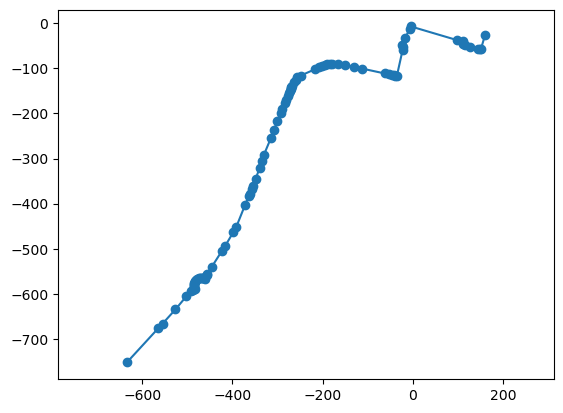

In [4]:
nodes_proj, edges_proj = ox.graph_to_gdfs(G, nodes=True, edges=True) #gdfs = geodataframe, which is the frame of the graph

# TODO: convert to local coordinates 
wpts = gdfs_to_local(nodes_proj, route)
plt.plot(wpts[:,0], wpts[:,1], 'o-')
plt.axis("equal")
plt.show()
#check slide for transformation g2c_rgf

# Task 2: Implement a Global Planner
- In this task, y.
- You also create a custom A* algorithm and heuristic function to find ou load a pre-existing road network graph (Town 01 Road Network) and actor positionsa path from the ego vehicle's current position to a specified target

In [5]:
import pickle

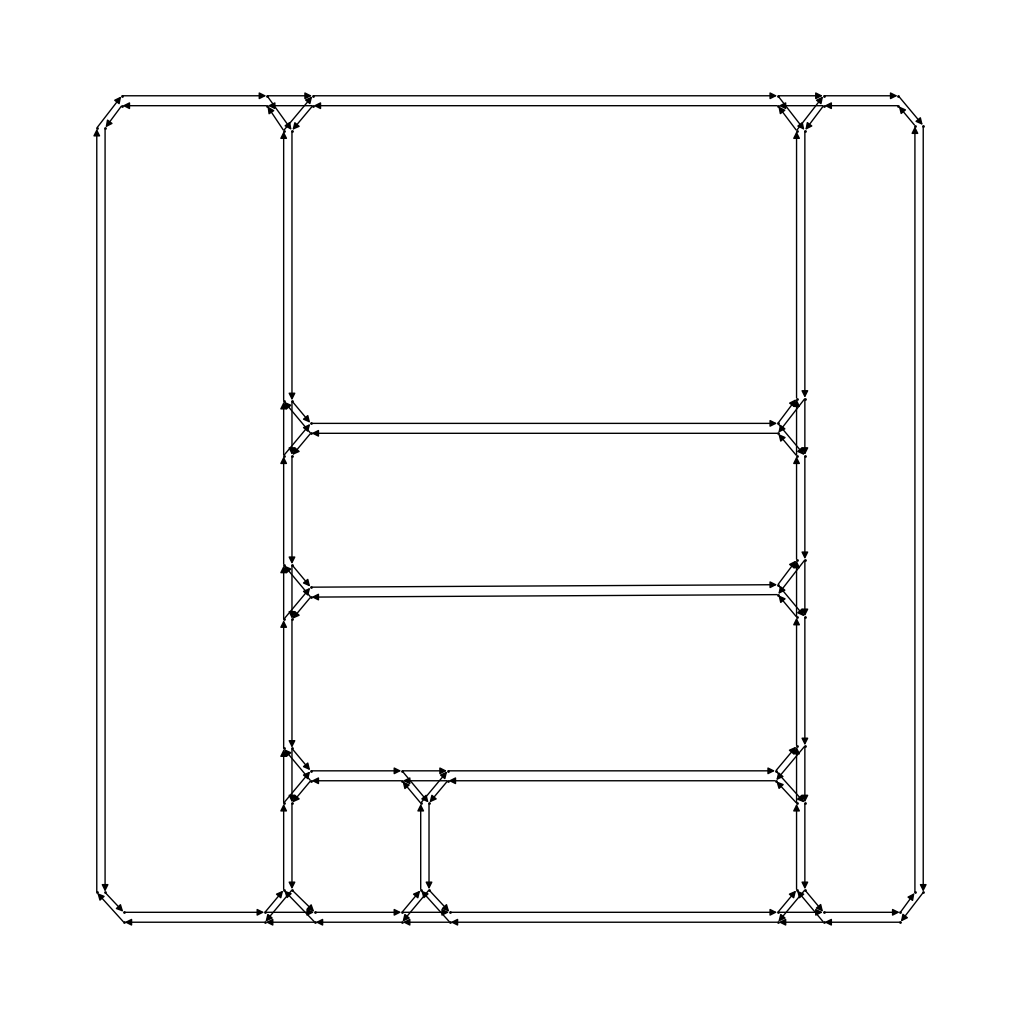

In [11]:
nodes =  pickle.load(open('/home/emanuele/Desktop/ECN_AUVE_labs/lab2_data/Town01_nodes.pickle', 'rb'))
edges =  pickle.load(open('/home/emanuele/Desktop/ECN_AUVE_labs/lab2_data/Town01_edges.pickle', 'rb'))

G = nx.DiGraph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)
node_positions = {waypoint[0]: (waypoint[1]["vertex"][0], waypoint[1]["vertex"][1]) for waypoint in G.nodes.data()}


# Draw the graph via networkx and matplotlib
plt.figure(figsize=(10,10)) # make the figure size
nx.draw(G, pos=node_positions, node_size=1, node_color='k') # draw the graph
plt.show() # show the graph


In [12]:
from utils import get_actor_T_world

actors = ["ego_vehicle" ,"other_vehicle",   "ego_vehicle_behind","other_vehicle_behind"]
N_frames = 100 


In [13]:
# Define a custom A* algorithm TODO: implement the algorithm

def custom_a_star(graph, start, end, heuristic_func):
    ''' A* algorithm: find the shortest path between two nodes in a graph
    Args:
        graph (networkx.Graph): graph
        start (int): starting node
        end (int): ending node
        heuristic_func (function): heuristic function
    Returns:
        path (list): list of nodes in the path'''
    open_set = {start}
    came_from = {}
    # initialize g_score and f_score
    g_score = {node: float('inf') for node in graph.nodes} 
    # g_score = measure of the cost of getting from the start node to the current node
    g_score[start] = 0
    f_score = {node: float('inf') for node in graph.nodes} 
    # f_score = estimate of the additional cost of getting from the current node N to the goal node
    f_score[start] = heuristic_func(start, end) 

    while open_set:
        current = min(open_set, key=lambda node: f_score[node])
        if current == end:
            path = []
            while current in came_from: 
                path.append(current)
                current = came_from[current]
            path.append(start)
            path.reverse()
            return path

        open_set.remove(current)
        for neighbor in graph.neighbors(current):
            tentative_g_score =  g_score[current] + graph[current][neighbor]['length']
            if tentative_g_score < g_score[neighbor]:
                # TODO: update came_from
                came_from[neighbor] = current
                
                # TODO: update g_score and f_score
                g_score[neighbor] = tentative_g_score
                f_score[neighbor] = g_score[neighbor] + heuristic_func(neighbor, end)
    
                # TODO: add neighbor to open_set if not already in
                if neighbor not in open_set:
                    open_set.add(neighbor)                
    
    return [start, end]

# Define a custom heuristic function (e.g., Euclidean distance)
def custom_heuristic(node, end):
    ''' Custom heuristic function: Euclidean distance
    Args:
        node (int): current node
        end (int): ending node
    Returns:    
        distance (float): Euclidean distance between the two nodes'''
    x1, y1 = node_positions[node]
    x2, y2 = node_positions[end]
    distance = ((x1-x2)**2 + (y1-y2)**2)**0.5
    return distance


    

Sequence of choosen Node: [77, 49, 30, 55, 43, 44, 47]


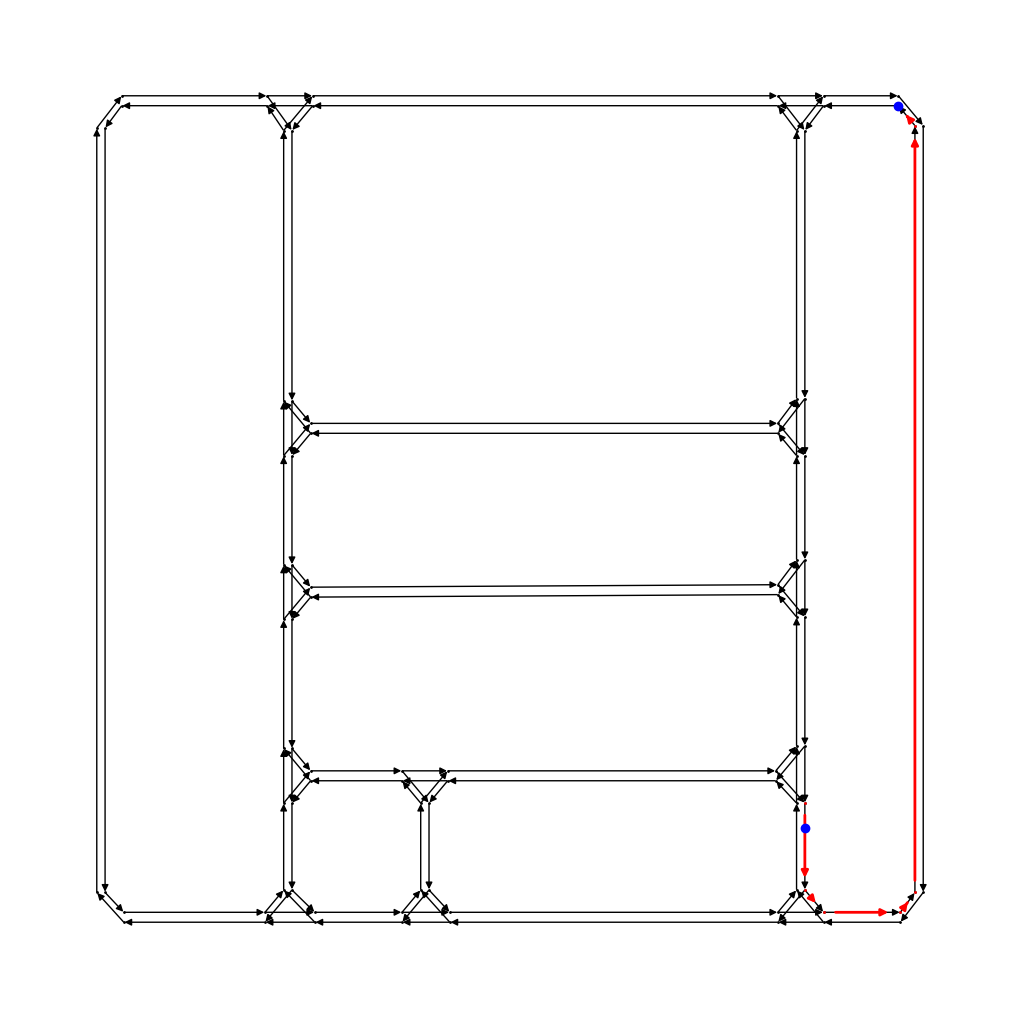

In [14]:
# find closest node to ego vehicle
ego_vehicle = "ego_vehicle"
ego_vehicle_pos = get_actor_T_world(ego_vehicle, 0)
ego_vehicle_pos = ego_vehicle_pos[:2,-1]

def closest_node(G, pos):
    # Find the closest node to the ego vehicle
    closest_node = min(G.nodes, key=lambda node: ((pos[0] - G.nodes[node]['vertex'][0]) ** 2 + (pos[1] - G.nodes[node]['vertex'][1]) ** 2) ** 0.5)
    return closest_node

origin = closest_node(G, ego_vehicle_pos)
end = 47
path = custom_a_star(G, origin, end, custom_heuristic)
print('Sequence of choosen Node:', path)

# Get the edges in the path 
path_edges = [(path[i], path[i + 1]) for i in range(len(path) - 1)]

# Draw the graph and the path on top of the graph
plt.figure(figsize=(10,10))
nx.draw(G, pos=node_positions, node_size=1, node_color='k')
nx.draw_networkx_nodes(G, pos=node_positions, nodelist=path, node_size=1, node_color='r')
nx.draw_networkx_edges(G, pos=node_positions, edgelist=path_edges, edge_color='r', width=2)

#------ additional --------#
#plot dot on starting position of ego vehicle
plt.plot(ego_vehicle_pos[0], ego_vehicle_pos[1], 'bo')
#plot dot on ending position of ego vehicle
plt.plot(G.nodes[end]['vertex'][0], G.nodes[end]['vertex'][1], 'bo')
#--------------------------#

plt.show()



# Task 3: Implement a Local Planner - DWA Approach
- This task implements the Dynamic Window Approach (DWA) for local planning. It defines various parameters such as maximum velocity, acceleration, and rotation.
- It simulates the DWA algorithm to generate a trajectory that minimizes a cost function. The trajectory is then plotted.

In [24]:
# Constants
MAX_VELOCITY = 13.0  # Maximum linear velocity (m/s)  # 13.0
MAX_ACCELERATION = 0.2  # Maximum linear acceleration (m/s^2) # 0.2
MAX_ROTATION = 2.0  # Maximum rotational velocity (rad/s)  # 2.0


# DWA parameters
NUM_THETA = 11  # Number of angular velocity samples 
NUM_V = 11  # Number of linear velocity samples
DT = 0.1  # Time step for simulation

# Function to calculate a cost for a given trajectory
def calculate_cost(trajectory, target, obstacles):
    # Implement your cost function here, considering factors like minimizing distance to target and minimizing speed norm.
    x = trajectory[-1][0] 
    y = trajectory[-1][1]
    #calculate distance from target
    dist_cost = np.sqrt((x - target[0])**2 + (y - target[1])**2)
    speed_cost = 0

    # Penalize collisions with obstacles
    collision_penalty = 0
    for point in trajectory:
        for obstacle in obstacles:
            if np.linalg.norm(point[:2] - obstacle) < 10.0: 
                collision_penalty += np.linalg.norm(point[:2] - obstacle)
                print("Collision detected!", collision_penalty)

    for index in range(len(trajectory)-1):
        #calculate speed norm
        w = np.abs(trajectory[index][2] - trajectory[index+1][2])/DT #angular velocity as the difference between two consecutive thetas divided by the time step
        speed_cost =  speed_cost + w  

    #normalize speed cost so that it weights lot more than distance cost
    #introduce speed cost weight
    speed_cost_weight = 1
    speed_cost = speed_cost * speed_cost_weight
    # introduce distance cost weight
    dist_cost_weight = 1000 #100
    dist_cost = dist_cost * dist_cost_weight
    
    
    print("Distance cost:", dist_cost)
    print("Speed cost:", speed_cost)
    print("Collision penalty:", collision_penalty)

    
    return  collision_penalty  + dist_cost + speed_cost
# Evolution model 
def evolve(current_state, v, w):
    x, y, theta = current_state
    
    # TODO: Implement the evolution model here
    x =x + v * np.cos(theta) * DT
    y =y + v * np.sin(theta) * DT
    theta = theta +  w * DT
    

    return np.array([x, y, theta])

# DWA algorithm
def dynamic_window_approach(current_state, target, obstacles):
    best_trajectory = None
    best_commands = None
    min_cost = float('inf') 

    for v in np.linspace(4.0, MAX_VELOCITY, NUM_V): 
        v = -v
        for w in np.linspace(-MAX_ROTATION, MAX_ROTATION, NUM_THETA):
            # Simulate the trajectory
            trajectory = [np.array(current_state)]
            for _ in range(10):  # Simulate for 1 second with evolution model 
                trajectory.append(evolve(trajectory[-1], v, w))


            # Calculate the cost of the trajectory
            cost = calculate_cost(trajectory, target, obstacles)

            # TODO :Update the best trajectory here
            if cost < min_cost:
                min_cost = cost
                best_trajectory = trajectory
                best_commands = [v, w]
            



    return best_trajectory, best_commands

Distance cost: 22936.346113602445
Speed cost: 20.0
Collision penalty: 0
Distance cost: 22305.007742619568
Speed cost: 16.000000000000004
Collision penalty: 0
Distance cost: 21732.184602563222
Speed cost: 12.000000000000002
Collision penalty: 0
Distance cost: 21272.07554194438
Speed cost: 8.000000000000004
Collision penalty: 0
Distance cost: 20972.16264070002
Speed cost: 4.0000000000000036
Collision penalty: 0
Distance cost: 20865.39412292509
Speed cost: 0.0
Collision penalty: 0
Distance cost: 20963.861025872986
Speed cost: 4.0000000000000036
Collision penalty: 0
Distance cost: 21256.285993059537
Speed cost: 8.000000000000007
Collision penalty: 0
Distance cost: 21710.37032603836
Speed cost: 12.00000000000001
Collision penalty: 0
Distance cost: 22279.020335036672
Speed cost: 16.000000000000014
Collision penalty: 0
Distance cost: 22908.15486755792
Speed cost: 20.000000000000014
Collision penalty: 0
Distance cost: 22549.101651550885
Speed cost: 20.0
Collision penalty: 0
Distance cost: 2176

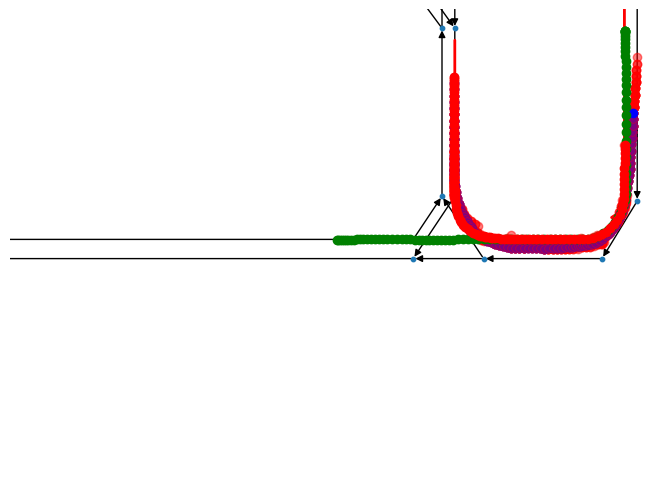

In [25]:
# Example usage
current_state = np.concatenate((ego_vehicle_pos,np.array(np.pi/2).reshape(1,))) # Initial state (x, y, theta)


obstacles = []  # List of obstacle positions, none for now

# Visualize the graph
nx.draw(G, node_positions,node_size=10)
nx.draw_networkx_edges(G, node_positions, edgelist=path_edges, edge_color='r', width=2)


path_loop = [G.nodes[path[i+1]]["vertex"] for i in range(len(path)-1)] # Loop over the global path
next_waypoint = path_loop.pop(0)
i=0
while path_loop and i<100: #100
    if np.linalg.norm(current_state - np.array(next_waypoint)) < 5.0:
        next_waypoint = path_loop.pop(0)
        
    resulting_trajectory, cmds = dynamic_window_approach(current_state, np.array(next_waypoint), obstacles)
    
    # Move along the trajectory (simulated)
    for state in resulting_trajectory:
        current_state = state
        plt.plot(current_state[0], current_state[1], 'ro', alpha=0.5) # Plot the current state in red

    current_state = resulting_trajectory[1]
    plt.plot(current_state[0], current_state[1], 'bo') # Plot the current state in blue
    i+=1
print("Next waypoint:", next_waypoint)

plt.xlim(200,400)
plt.ylim(-50,50) #50



for n_frame in range(N_frames):

    T_ego = get_actor_T_world(ego_vehicle, n_frame)
    #plt.scatter(T_ego[0,3], T_ego[1,3], 'r') 
    T_actor = get_actor_T_world("other_vehicle", n_frame)
    #plt.scatter(T_actor[0,3], T_actor[1,3], 'g') 

    # TODO: Plot the trajectory of the ego vehicle and the other vehicle
    plt.plot(T_ego[0,3], T_ego[1,3], 'ro')
    plt.plot(T_actor[0,3], T_actor[1,3], 'go') 
     
    #plot multiple frames on the same graph
print("ego vehicle position:", ego_vehicle_pos)
print("current_state:", current_state)
plt.show()





# Task 4: Implement a DWA Approach with Obstacle Avoidance
- This task extends the DWA approach to include obstacle avoidance. Obstacle positions (both static and dynamic) are considered when calculating the cost of a trajectory.
- The code predicts the future positions of dynamic obstacles.
- It then simulates the DWA approach while avoiding both static and dynamic obstacles.

In [17]:
ROBOT_RADIUS = 3 # Robot radius (m)
OBS_RADIUS = 3  # Radius of obstacles (m)
DT = 0.1  # Time step for simulation
# Function to calculate a cost for a given trajectory considering proximity to obstacles
def calculate_cost(trajectory, target, obstacles, dynamic_obstacles):
    dist_cost = np.linalg.norm(trajectory[-1][:2] - target[:2])
    speed_cost = 0
    for index in range(len(trajectory)-1):
        #calculate speed norm
        w = np.abs(trajectory[index][2] - trajectory[index+1][2])/DT
        speed_cost = w    
    
    # Add a penalty for proximity to static obstacles
    # Penalize collisions with obstacles
    collision_penalty = 0
    for point in trajectory:
        for obstacle in obstacles:
            if np.linalg.norm(point[:2] - obstacle) < OBS_RADIUS + ROBOT_RADIUS:
                collision_penalty += np.linalg.norm(point[:2] - obstacle)
                print("Collision detected!", collision_penalty)
    dynamic_collision_penalty = 0
    # Add a penalty for proximity to dynamic obstacles
    for obs in dynamic_obstacles:
        obs_trajectory = predict_dynamic_obstacles(obs, len(trajectory))
        #plot dynamic obstacles in green
        #plt.plot(obs_trajectory[1][0], obs_trajectory[1][1], 'go')
        for i in range(len(trajectory)):
            distance = np.linalg.norm(trajectory[i][:2] - obs_trajectory[i])
            if distance < ROBOT_RADIUS + OBS_RADIUS + 50: #+50
                dynamic_collision_penalty += (ROBOT_RADIUS + OBS_RADIUS - distance)
                print("Dynamic Collision detected!", distance, dynamic_collision_penalty)

    #introduce speed cost weight
    speed_cost_weight = 1
    speed_cost = speed_cost * speed_cost_weight
    # introduce distance cost weight
    dist_cost_weight = 1000 #100
    dist_cost = dist_cost * dist_cost_weight
    #introduce collision penalty weight
    collision_penalty_weight = 1
    collision_penalty = collision_penalty * collision_penalty_weight
    #introduce weight for dynamic collision penalty
    dynamic_collision_penalty_weight = 100
    dynamic_collision_penalty = dynamic_collision_penalty_weight * dynamic_collision_penalty
    # print("Distance cost:", dist_cost)
    # print("Speed cost:", speed_cost)
    # print("Collision penalty:", collision_penalty)
    # print("Dynamic collision penalty:", dynamic_collision_penalty)
    return collision_penalty + dist_cost + speed_cost + dynamic_collision_penalty

# Function to predict future positions of dynamic obstacles
def predict_dynamic_obstacles(dynamic_obstacle, num_steps):
    x,y,v_x, v_y = dynamic_obstacle
    positions = []

    # TODO: Implement the prediction of future positions of dynamic obstacles
    for i in range(num_steps):
        x = x + v_x * DT
        y = y + v_y * DT
        positions.append(np.array([x, y]))
        #print("positions:", positions)
    
    return positions

# DWA algorithm with dynamic obstacle avoidance and proximity to obstacles
def dynamic_window_approach_avoidance(current_state, target, obstacles, dynamic_obstacles):
    best_trajectory = None
    min_cost = float('inf')

    # Predict future positions of dynamic obstacles
    num_prediction_steps = 10

    for v in np.linspace(0, MAX_VELOCITY, NUM_V):
        v = -v
        for w in np.linspace(-MAX_ROTATION, MAX_ROTATION, NUM_THETA):
            # Simulate the trajectory
            trajectory = [np.array(current_state)]
            for _ in range(num_prediction_steps):  # Simulate for predicted time
                trajectory.append(evolve(trajectory[-1], v, w))

            # Calculate the cost of the trajectory
            cost = calculate_cost(trajectory, target, obstacles, dynamic_obstacles)

            # TODO :Update the best trajectory here
            if cost < min_cost:
                min_cost = cost
                best_trajectory = trajectory

    return best_trajectory

Dynamic Collision detected! 48.74267298893084 -42.74267298893084
Dynamic Collision detected! 47.4794212490019 -84.22209423793274
Dynamic Collision detected! 46.250183936655844 -124.47227817458858
Dynamic Collision detected! 45.057745019128774 -163.53002319371734
Dynamic Collision detected! 43.90510287248111 -201.43512606619845
Dynamic Collision detected! 42.79547324516314 -238.23059931136157
Dynamic Collision detected! 41.73228728828313 -273.9628865996447
Dynamic Collision detected! 40.71918312474014 -308.68206972438486
Dynamic Collision detected! 39.75998926534622 -342.4420589897311
Dynamic Collision detected! 38.858698104990225 -375.30075709472135
Dynamic Collision detected! 38.019427802757555 -407.3201848974789
Dynamic Collision detected! 48.74267298893084 -42.74267298893084
Dynamic Collision detected! 47.4794212490019 -84.22209423793274
Dynamic Collision detected! 46.250183936655844 -124.47227817458858
Dynamic Collision detected! 45.057745019128774 -163.53002319371734
Dynamic Colli

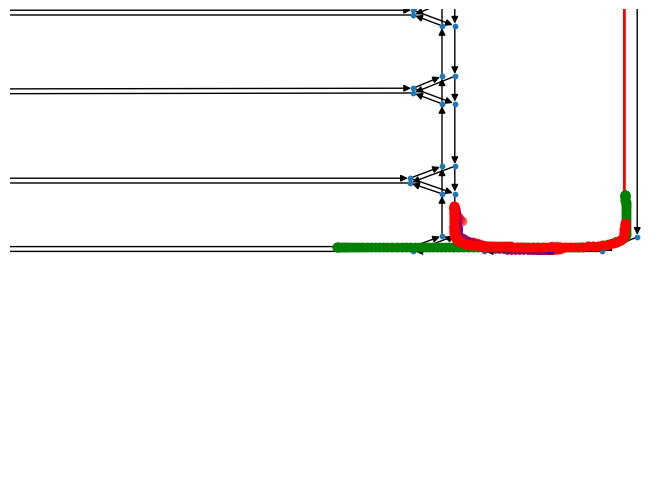

In [18]:
# Example usage
current_state = np.concatenate((ego_vehicle_pos,np.array(np.pi/2).reshape(1,))) # Initial state (x, y, theta)

obstacles = []  # List of obstacle positions

# Draw the graph with nodes and path edges
nx.draw(G, node_positions,node_size=10)
nx.draw_networkx_edges(G, node_positions, edgelist=path_edges, edge_color='r', width=2)

path_loop = [G.nodes[path[i+1]]["vertex"] for i in range(len(path)-1)]
next_waypoint = path_loop.pop(0)

# get the position of the other vehicle
x,y  = get_actor_T_world('other_vehicle', 0)[:2,-1]
# here we assume that the other vehicle is moving with a constant longitudinal velocity and no lateral velocity
dynamic_obstacles = [(x,y,17.8,0.0)] #17.8
#plot dynamic obstacles in black
plt.plot(x, y, 'ko')


i=0
while path_loop and i<100:
    # Check if the current state is close to the next waypoint and update the next waypoint
    if np.linalg.norm(current_state - np.array(next_waypoint)) < 5.0:
        next_waypoint = path_loop.pop(0)

    # Compute the trajectory using dynamic window approach and avoidance
    resulting_trajectory  = dynamic_window_approach_avoidance(current_state, np.array(next_waypoint), obstacles, dynamic_obstacles)
    #plot the resulting trajectory and the next waypoint
    for state in resulting_trajectory:
        current_state = state
        plt.plot(current_state[0], current_state[1], 'ro', alpha=0.5)
    #plt.plot(next_waypoint[0], next_waypoint[1], 'bo')
    
    # Move along the trajectory (simulated) and plot the trajectory
    current_state = resulting_trajectory[1]
    i+=1
    plt.plot(current_state[0], current_state[1], 'bo')
#plt.show()
print("Next waypoint:", next_waypoint)
# Set the limits of the plot
plt.xlim(200,400)
plt.ylim(-200,200)
#plt.show()

for n_frame in range(N_frames):

    T_ego = get_actor_T_world(ego_vehicle, n_frame)
    #plt.scatter(T_ego[0,3], T_ego[1,3], 'r') 
    T_actor = get_actor_T_world("other_vehicle", n_frame)
    #plt.scatter(T_actor[0,3], T_actor[1,3], 'g') 

    # TODO: Plot the trajectory of the ego vehicle and the other vehicle
    plt.plot(T_ego[0,3], T_ego[1,3], 'ro')
    plt.plot(T_actor[0,3], T_actor[1,3], 'go') 
     
    #plot multiple frames on the same graph
print("ego vehicle position:", ego_vehicle_pos)
print("current_state:", current_state)
plt.show()

